# Cisco - Ariel University API Security Detection Challenge 2023
## Baseline code


### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfTransformer

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 2 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 




### Basic dataset label arrangements

In [2]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)
df.head()
column_list=df.columns.to_list()


In [3]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
def  notn(d):
    for column in d.columns[d.isna().any()].tolist():
        # d.drop(column, axis=1, inplace=True)
        d[column] = d[column].fillna('None')
        d[column] = d[column].replace('""','None')
    d['request.body'] = d['request.body'].replace('','None')


    return d
    # If you want to detect columns that may have only some NaN values use this:
    # df.loc[:, df.isna().any()].tolist()
df=notn(df)

In [4]:
#This function add all the new features we've create to maximize our model
def addfunc(df):
    #create new DataFrame for idwntify the log4j attack
    LOGdf=pd.DataFrame()
    #create colums acording to excist featurs
    LOGdf['encoding']=df['request.headers.Accept-Encoding']
    LOGdf['site']=df['request.headers.Sec-Fetch-Site']
    LOGdf['dest']=df['request.headers.Sec-Fetch-Dest']
    #lambda functions for adding numbers to the colums we've created according to their values
    LOGdf['encoding'] =LOGdf['encoding'].apply(lambda x: 0 if  x == 'gzip, deflate, br' else 1)
    LOGdf['site'] =LOGdf['site'].apply(lambda x: 0 if  x == 'none' else 1)
    LOGdf['dest'] =LOGdf['dest'].apply(lambda x: 0 if  x == 'document' else 1)
    #create new colum that sum the colums above for checking if any of them has valuse of 1
    LOGdf['count'] =LOGdf['dest']+LOGdf['site']+LOGdf['encoding']
    #filling NaN with 0
    LOGdf['count'] = LOGdf['count'].fillna(0)
    #replacing any x>1 with 1
    LOGdf["count"]=LOGdf['count'].apply(lambda x: True if  x > 0 else False)
    df["LogAn"]=LOGdf['count']
    #create 2 featurs that calculate the len of their headers 
    df["request.url_sql"]=df["request.url"].str.len()
    df["resBodLen"]=df["response.body"].str.len()
    #completing featur for detact the log4j attack 
    df["jndi"]=df["request.headers.Set-Cookie"].apply(lambda x: 1 if "${jndi:" in x else 0)



In [5]:
# On these headers we will run LevelEncoder
SIMPLE_HEADERS = [
                'request.method',
                'request.headers.Accept-Language',
                'response.headers.Content-Type',
                'request.headers.Content-Length',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.User-Agent',
                'response.body',
                'request.headers.Sec-Fetch-Dest', 
                'request.headers.Sec-Fetch-Site',
                'request.headers.Accept-Encoding',
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = [
                    'response.headers.Location',
                    'request.headers.Cookie',
                    'request.headers.Set-Cookie',
                    ]

COLUMNS_TO_REMOVE = ['request.headers.Date',
                     'response.status',
                     'response.status_code',
                     'request.body',
                     'response.headers.Set-Cookie',
                     'response.headers.Content-Length',
                     'request.headers.Sec-Fetch-User',
                     'request.url',
                     'request.headers.Connection',                   
                     'request.headers.Accept',                 
                     'request.headers.Host',
                     'request.headers.Sec-Fetch-Dest', 
                     'request.headers.Sec-Fetch-Site',
                    ]


# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    #add the features with function below
    addfunc(df)
    #define the LabelEncoder and HashingVectorizer
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=2)
    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] =le.fit_transform(df[column])
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()
    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

#call function above
df = vectorize_df(df)
df.head()


,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept-Language,request.headers.Sec-Fetch-Mode,request.headers.Set-Cookie,request.method,response.headers.Content-Type,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,attack_type,label,LogAn,request.url_sql,resBodLen,jndi
0,11,0,1,0,-0.780869,0,0,4763,-1.0,-1.0,1,Benign,Benign,False,46,27,0
1,28,0,3,0,-0.800000,0,1,8,-1.0,-1.0,1,Benign,Benign,False,39,1163,0
2,16,0,1,1,-0.316228,0,0,4415,-1.0,-1.0,1,Benign,Benign,False,42,933,0
3,2,0,2,0,-0.752577,0,0,4768,-1.0,-1.0,1,Benign,Benign,False,33,28,0
4,17,0,3,1,-0.877896,0,0,4767,-1.0,-1.0,1,Benign,Benign,False,47,31,0


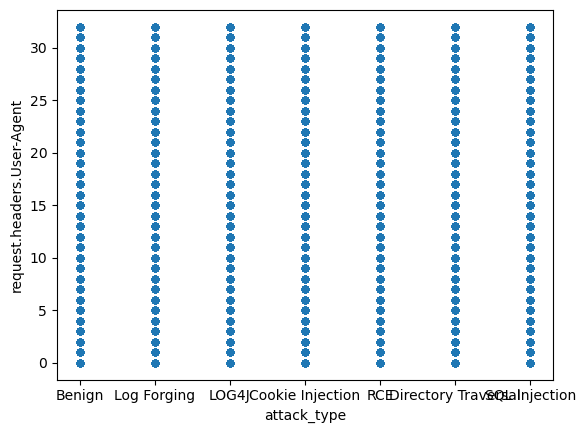

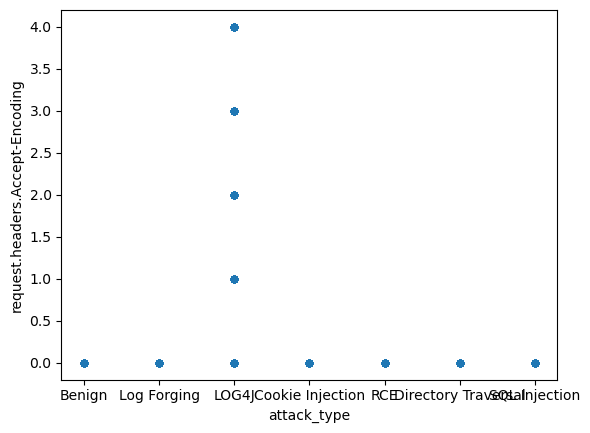

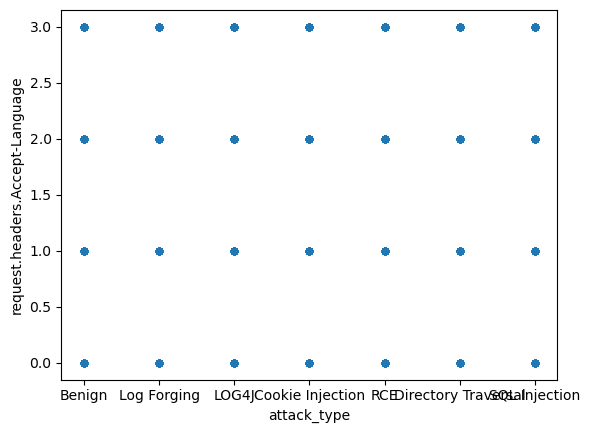

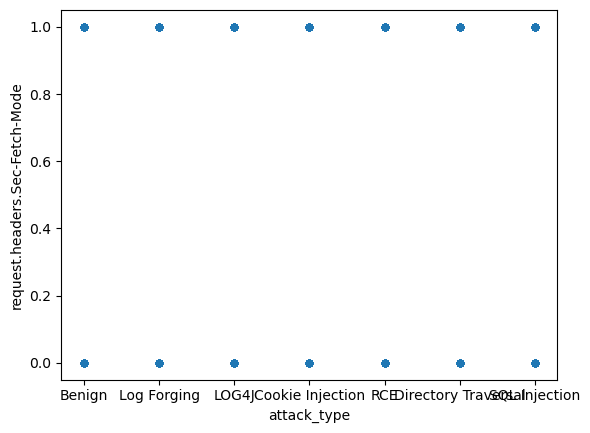

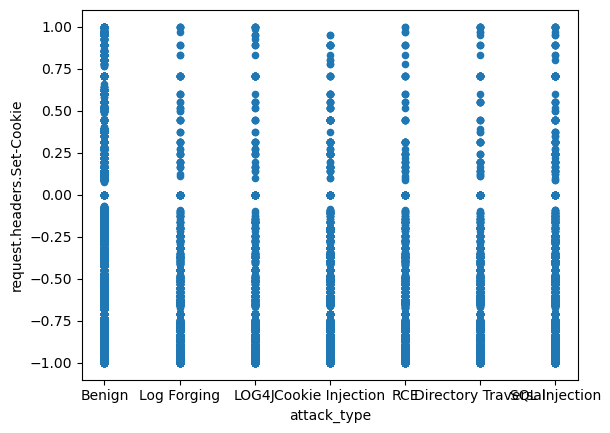

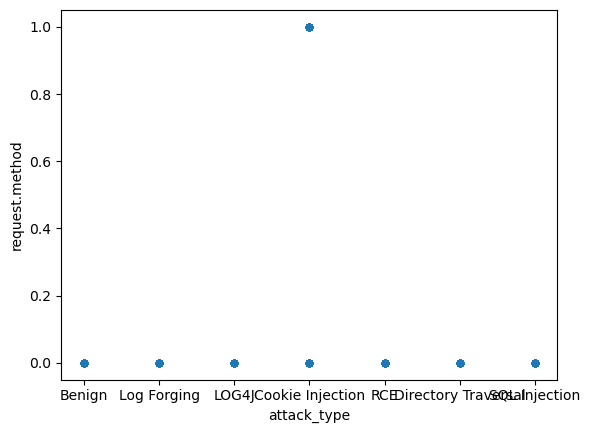

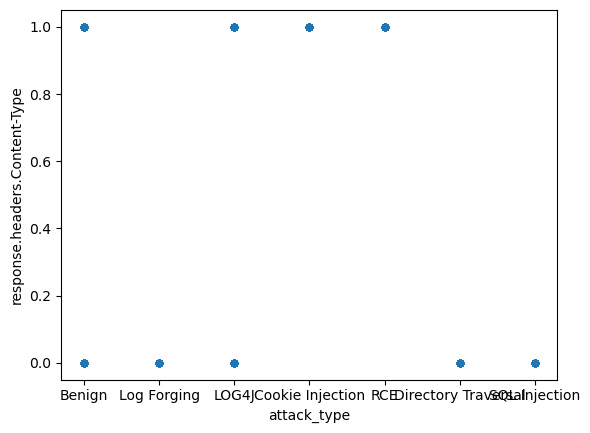

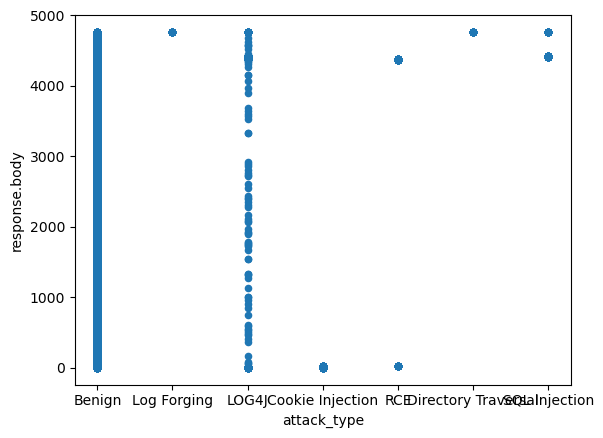

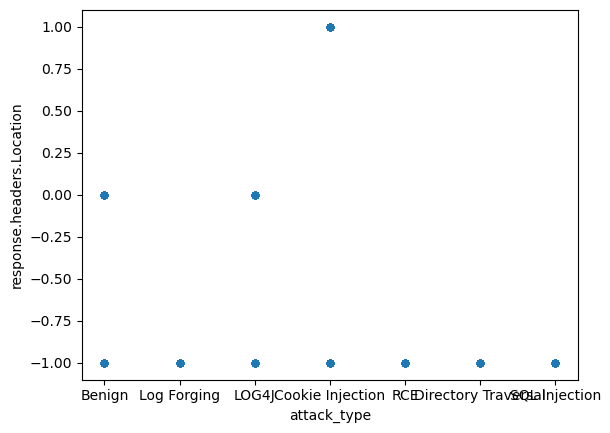

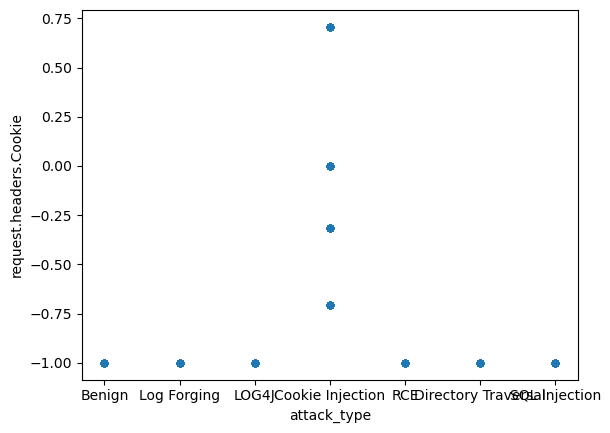

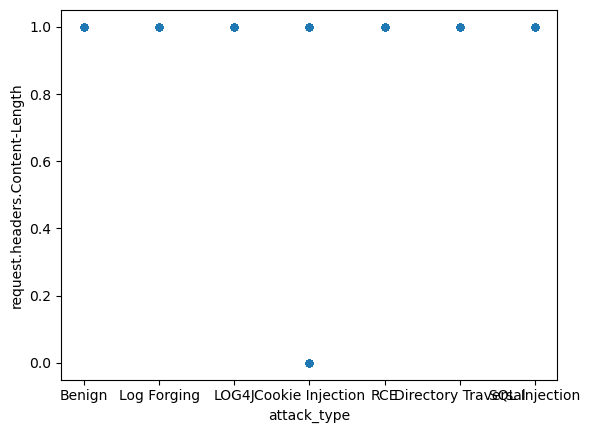

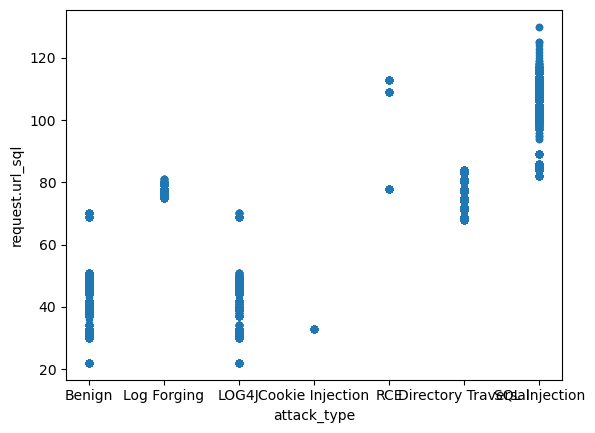

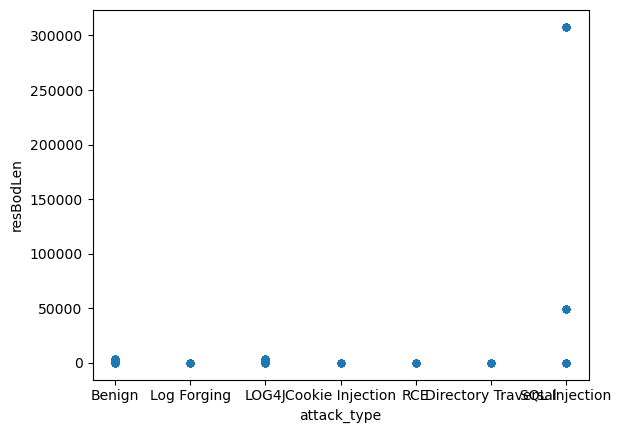

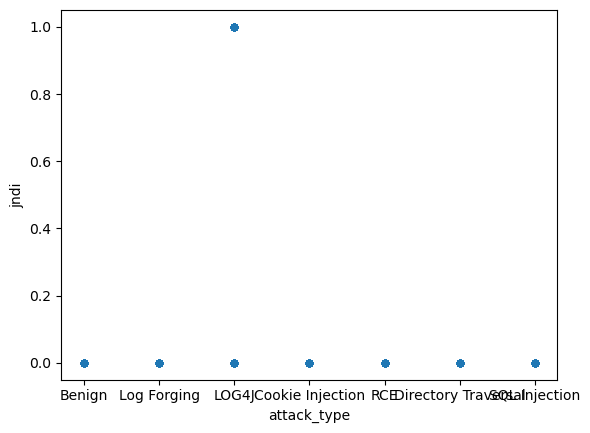

In [6]:
#creating a list of all the colums in the DataFrame
df_col=(df.columns.to_list())
#printing graphs of all the columns for observing anomalies
for i in df_col:
    if i!= "attack_type" and i!="label" and i!="incoockie" and i!="LogAn":
        var = 'attack_type'
        data = pd.concat([df[i], df[var]], axis=1)
        data.plot.scatter(x=var, y=i ); 


In [7]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127500 entries, 0 to 127499
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   request.headers.User-Agent       127500 non-null  int32  
 1   request.headers.Accept-Encoding  127500 non-null  int32  
 2   request.headers.Accept-Language  127500 non-null  int32  
 3   request.headers.Sec-Fetch-Mode   127500 non-null  int32  
 4   request.headers.Set-Cookie       127500 non-null  float64
 5   request.method                   127500 non-null  int32  
 6   response.headers.Content-Type    127500 non-null  int32  
 7   response.body                    127500 non-null  int32  
 8   response.headers.Location        127500 non-null  float64
 9   request.headers.Cookie           127500 non-null  float64
 10  request.headers.Content-Length   127500 non-null  int32  
 11  attack_type                      127500 non-null  object 
 12  la

In [8]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.
features_list = df.columns.to_list()

#remove the defintions features before the test
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Mode', 'request.headers.Set-Cookie', 'request.method', 'response.headers.Content-Type', 'response.body', 'response.headers.Location', 'request.headers.Cookie', 'request.headers.Content-Length', 'LogAn', 'request.url_sql', 'resBodLen', 'jndi']


request.headers.User-Agent           int32
request.headers.Accept-Encoding      int32
request.headers.Accept-Language      int32
request.headers.Sec-Fetch-Mode       int32
request.headers.Set-Cookie         float64
request.method                       int32
response.headers.Content-Type        int32
response.body                        int32
response.headers.Location          float64
request.headers.Cookie             float64
request.headers.Content-Length       int32
attack_type                         object
label                               object
LogAn                                 bool
request.url_sql                      int64
resBodLen                            int64
jndi                                 int64
dtype: object

## Train test split

In [9]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=10, stratify=y)
# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(104996, 15) (104996,)
(22504, 15) (22504,)


Counter({'Benign': 117914, 'Malware': 9586})

## Model choosing and fitting

In [10]:
from sklearn.ensemble import AdaBoostClassifier

# We choose our model of choice and set it's hyper parameters you can change anything
clf =RandomForestClassifier(n_estimators=100, random_state=10)

# Train Model
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 97102), ('Malware', 7894)]


## Result printout

              precision    recall  f1-score   support

      Benign  1.0000000000 1.0000000000 1.0000000000     20812
     Malware  1.0000000000 1.0000000000 1.0000000000      1692

    accuracy                      1.0000000000     22504
   macro avg  1.0000000000 1.0000000000 1.0000000000     22504
weighted avg  1.0000000000 1.0000000000 1.0000000000     22504



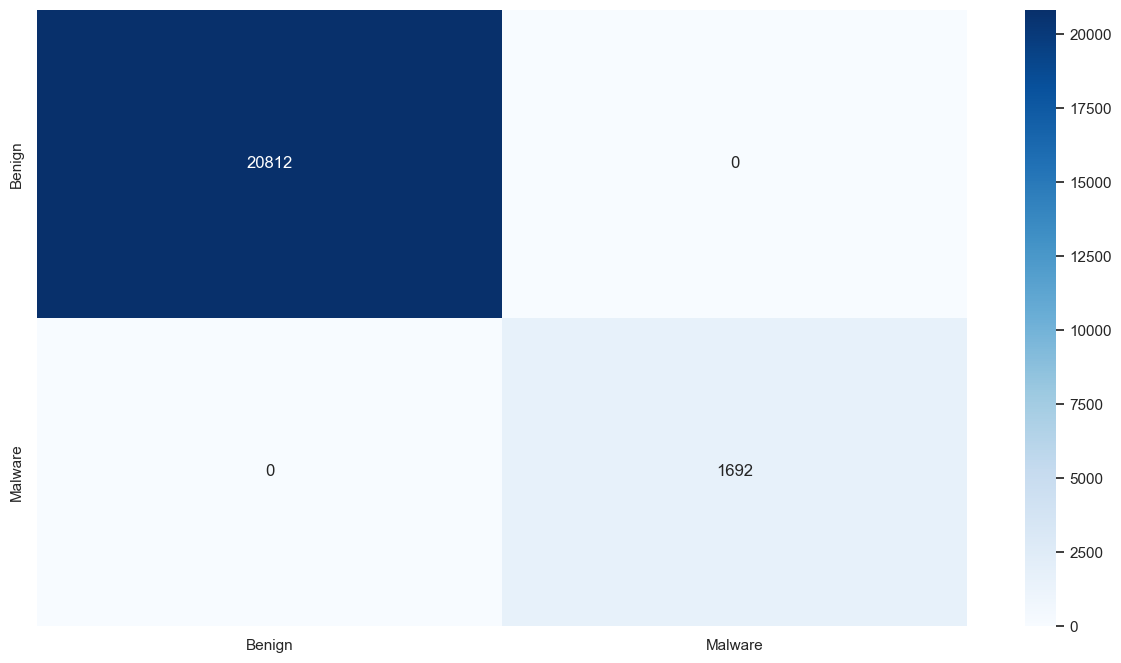

In [11]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=10)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

# Test

In [12]:
# Now it's your turn, use the model you have just created :)

# Read the valuation json, preprocess it and run your model 
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)
test_df=notn(test_df)
addfunc(test_df)
# rem(test_df)

# Preprocess the validation dataset, remember that here you don't have the labels
test_df = vectorize_df(test_df)

# Predict with your model
X = test_df[features_list].to_numpy()
predictions = clf.predict(X)


In [13]:
unique, counts = np.unique(predictions, return_counts=True)

dict(zip(unique, counts))


{'Benign': 20795, 'Malware': 1705}

# Save your predictions

In [14]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')